In [392]:
import pandas as pd
from sqlalchemy import create_engine
import os
import json
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def load_credentials(path = "aws_rds_credentials.json"):
     with open(path, 'r') as file:
          config = json.load(file)

     # set up credentials
     for key in config.keys():
          os.environ[key] = config[key]

     return

time_interval = 90 #days

load_credentials()

aws_rds_url = f"postgresql://{os.environ['user']}:{os.environ['password']}@{os.environ['host']}:{os.environ['port']}/{os.environ['database']}?sslmode=require"

engine = create_engine(aws_rds_url)
sql_query = f"""SELECT brand_title, price_numeric, status, catalog_id, size_title, color1_id
               FROM public.tracking_staging 
               WHERE date >= CURRENT_DATE - INTERVAL '{time_interval} days'
               LIMIT 100000
               """
data = pd.read_sql(sql_query, engine)
data

,brand_title,price_numeric,status,catalog_id,size_title,color1_id
0,,7,Muito bom,2364,,None
1,,3,Bom,2364,,None
2,,5,Novo com etiquetas,960,,12.0
3,,2,Bom,2333,,None
4,,5,Bom,2352,,None
...,...,...,...,...,...,...
99995,,3,Muito bom,534,L / 40 / 12,5.0
99996,Domyos,3,Muito bom,576,L / 40 / 12,3.0
99997,VTech,5,Muito bom,1763,Tamanho único,None
99998,,5,Bom,1057,M / 38 / 10,1.0


In [393]:
# Create pivot dataframes for each column
sum_volume = data["price_numeric"].sum()

#pivot_brand = data.pivot_table(values='price_numeric', columns='brand_title', index='catalog_id', aggfunc='sum')
#pivot_status = data.pivot_table(values='price_numeric', columns='status', index='catalog_id', aggfunc='sum')
pivot_size = data.pivot_table(values='price_numeric', columns='size_title', index='catalog_id', aggfunc='count')
#pivot_color = data.pivot_table(values='price_numeric', columns='color1_id', index='catalog_id', aggfunc='sum')


#pivot_combined = pd.concat([pivot_status, pivot_size, pivot_color, pivot_brand], axis = 1, ignore_index= False)
#pivot_combined
pivot_size


size_title,,0-13 kg,"0-3 meses, 30 cm","1-2 anos, 49 cm",1-3 meses / 56 cm,10 anos / 140 cm,100 cm,100 x 150 cm,105 cm,11 anos / 146 cm,110 cm,115 cm,12 anos / 152 cm,12 ou mais > 56 cm,12-18 meses / 80 cm,120 cm,120 x 160 cm,125 x 150 cm,13 anos / 158 cm,13-15,130 x 170 cm,14 anos / 164 cm,"14,1 mm Ø / 4","14,9 mm Ø / 6,5",15 anos / 170 cm,15 ou inferior,"15,3 mm Ø / 8","15,7 mm Ø / 9,5",150 cm - 199 cm,16,16 anos / 176 cm,"16,1 mm Ø / 10,5","16,5 mm Ø / 12","16,9 mm Ø / 13,5",16-18,17,"17,3 mm Ø / 14,5","17,7 mm Ø / 16",18,"18,1 mm Ø / 18,5",...,PT 34 | W25,PT 36 | W26,PT 36 | W27,PT 38 | W28,PT 38 | W29,PT 40 | W30,PT 40 | W31,PT 42 | W32,PT 42 | W33,PT 44 | W34,PT 44 | W35,PT 46 | W36,PT 48 | W38,PT 50 | W40,PT 52 | W42,PT 54 | W44,PT 56 | W46,PT 58 | W48,PT 60 | W50,"Prematuro, até 44 cm","Prematuros, 30 cm",Qualquer,"Recém-nascidos, 44 cm",S,S / 36 / 8,S | 35-38,S | 38-42,Solteiro (135-150 cm x 200-220 cm),Tamanho único,XL,XL / 42 / 14,XS,XS / 34 / 6,XXL,XXL / 44 / 16,XXS,XXS / 32 / 4,XXXL,XXXL / 46 / 18,XXXS / 30 / 2
catalog_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.0,NaN,NaN,NaN,8.0,NaN,13.0,NaN,65.0,NaN,14.0,NaN,3.0,NaN,9.0,5.0
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61.0,NaN,NaN,NaN,NaN,NaN,32.0,NaN,56.0,NaN,9.0,NaN,NaN,NaN,1.0,NaN
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,158.0,NaN,NaN,NaN,47.0,NaN,44.0,NaN,37.0,NaN,6.0,NaN,5.0,NaN,NaN,NaN
19,71.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,150.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2965,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [394]:
from sklearn.preprocessing import MinMaxScaler

pivot_combined = pivot_size.fillna(0)
pivot_combined = pivot_combined.T
for col in pivot_combined.columns:
    pivot_combined[col] = MinMaxScaler().fit_transform(X = pivot_combined[[col]]) #/pivot_combined[col].sum()
pivot_combined = pivot_combined.T
pivot_combined

size_title,,0-13 kg,"0-3 meses, 30 cm","1-2 anos, 49 cm",1-3 meses / 56 cm,10 anos / 140 cm,100 cm,100 x 150 cm,105 cm,11 anos / 146 cm,110 cm,115 cm,12 anos / 152 cm,12 ou mais > 56 cm,12-18 meses / 80 cm,120 cm,120 x 160 cm,125 x 150 cm,13 anos / 158 cm,13-15,130 x 170 cm,14 anos / 164 cm,"14,1 mm Ø / 4","14,9 mm Ø / 6,5",15 anos / 170 cm,15 ou inferior,"15,3 mm Ø / 8","15,7 mm Ø / 9,5",150 cm - 199 cm,16,16 anos / 176 cm,"16,1 mm Ø / 10,5","16,5 mm Ø / 12","16,9 mm Ø / 13,5",16-18,17,"17,3 mm Ø / 14,5","17,7 mm Ø / 16",18,"18,1 mm Ø / 18,5",...,PT 34 | W25,PT 36 | W26,PT 36 | W27,PT 38 | W28,PT 38 | W29,PT 40 | W30,PT 40 | W31,PT 42 | W32,PT 42 | W33,PT 44 | W34,PT 44 | W35,PT 46 | W36,PT 48 | W38,PT 50 | W40,PT 52 | W42,PT 54 | W44,PT 56 | W46,PT 58 | W48,PT 60 | W50,"Prematuro, até 44 cm","Prematuros, 30 cm",Qualquer,"Recém-nascidos, 44 cm",S,S / 36 / 8,S | 35-38,S | 38-42,Solteiro (135-150 cm x 200-220 cm),Tamanho único,XL,XL / 42 / 14,XS,XS / 34 / 6,XXL,XXL / 44 / 16,XXS,XXS / 32 / 4,XXXL,XXXL / 46 / 18,XXXS / 30 / 2
catalog_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.977273,0.0,0.0,0.0,0.090909,0.0,0.147727,0.000000,0.738636,0.0,0.159091,0.0,0.034091,0.0,0.102273,0.056818
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.000000,0.0,0.524590,0.000000,0.918033,0.0,0.147541,0.0,0.000000,0.0,0.016393,0.000000
16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.297468,0.0,0.278481,0.000000,0.234177,0.0,0.037975,0.0,0.031646,0.0,0.000000,0.000000
19,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.000000,0.0,0.0,0.0,1.000000,0.0,0.000000,0.033333,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
2965,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.000000,0.0,0.00000

In [395]:
(pivot_combined == 0).sum(axis=1)
(pivot_combined != 0).mean(axis=1)

catalog_id
11      0.047619
14      0.027778
16      0.023810
18      0.039683
19      0.003968
          ...   
2964    0.019841
2965    0.003968
2968    0.011905
2969    0.027778
2970    0.027778
Length: 812, dtype: float64

In [396]:
# lets create a function to clean up the dataframe
#threshold = 0.001
#pivot_combined = pivot_combined.applymap(lambda x: 0 if x < threshold else x*1.5 if x > 0.05 else x) 
pivot_combined = pivot_combined.T
#pivot_combined


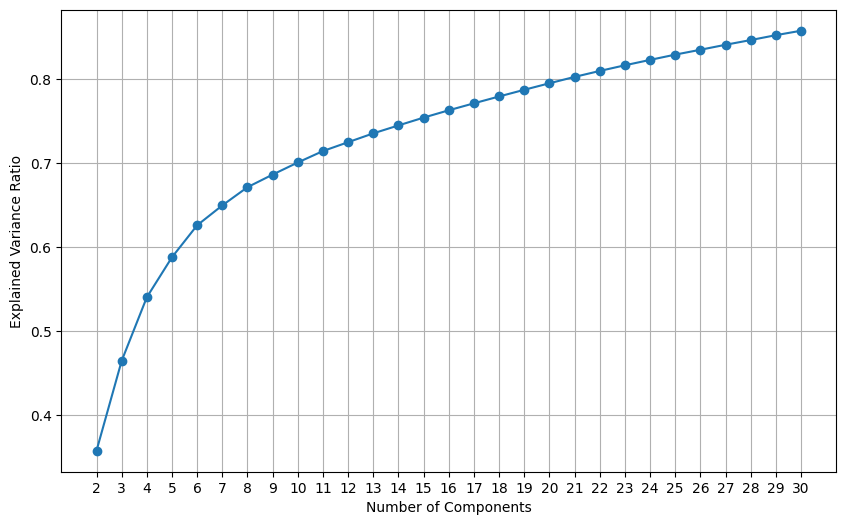

In [397]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Initialize lists to store explained variance ratios
explained_variances = []

# Fit PCA with 2 to 10 components and store explained variance ratios
for n_components in range(2, 31):
    pca = PCA(n_components=n_components)
    pca.fit(pivot_combined)
    explained_variances.append(sum(pca.explained_variance_ratio_))

# Plot the explained variance ratios
plt.figure(figsize=(10, 6))
plt.plot(range(2, 31), explained_variances, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(2, 31))
plt.grid(True)

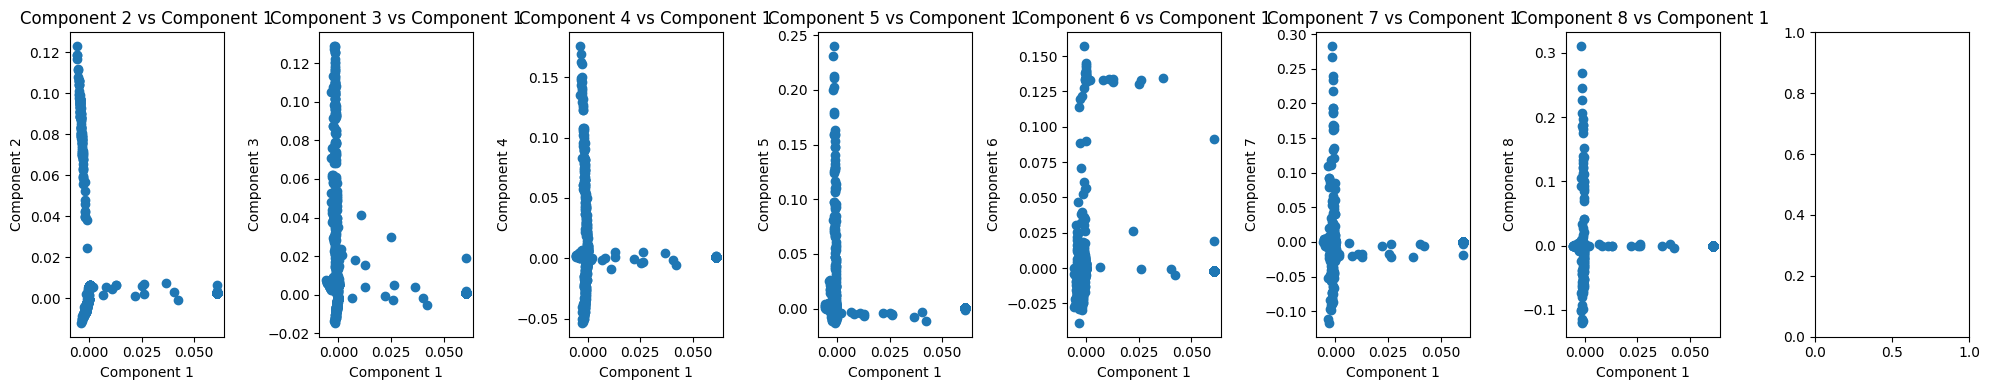

In [398]:
n_comps = 8

pca = PCA(n_components=n_comps)
pca.fit(pivot_combined)
transformed = pca.transform(pivot_combined)
# Fix component 1 as X
X_fixed = pca.components_[0]

# Create subplots for the other components
fig, axs = plt.subplots(1, n_comps, figsize=(20, 4))

# Plot each component against component 1
for i in range(1, n_comps):  # Start from component 2 (index 1)
    axs[i-1].scatter(X_fixed, pca.components_[i])
    axs[i-1].set_title(f'Component {i+1} vs Component 1')
    axs[i-1].set_xlabel('Component 1')
    axs[i-1].set_ylabel(f'Component {i+1}')

plt.tight_layout()

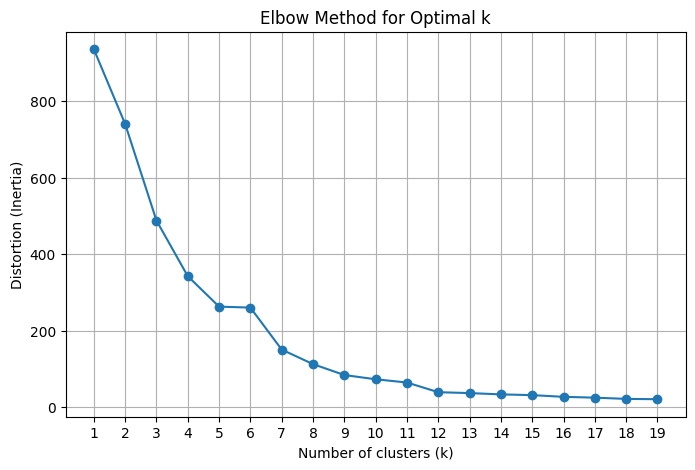

In [399]:
from sklearn.cluster import KMeans

distortions = []

clusters_n = 20

for k in range(1, clusters_n):
    kmeans = KMeans(n_clusters=k, max_iter= 500)
    kmeans.fit(pd.DataFrame(transformed))
    distortions.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(8, 5))
plt.plot(range(1, clusters_n), distortions, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Distortion (Inertia)')
plt.xticks(range(1, clusters_n))
plt.grid(True)

In [400]:
kmeans = KMeans(n_clusters=9)
kmeans.fit(pd.DataFrame(transformed))
# Compute cluster labels for the transformed data
labels = kmeans.predict(pd.DataFrame(transformed))

# Append the labels to the original DataFrame
data_with_labels = pd.concat([pd.DataFrame(pivot_combined), pd.DataFrame(labels, columns=['Cluster'], index = pivot_combined.index)], axis=1)
#data_with_labels.index = pivot_combined.index
data_with_labels

,11,14,16,18,19,20,22,26,83,84,86,87,88,89,90,91,92,94,96,97,98,99,119,120,123,124,141,143,145,152,153,156,157,158,159,160,161,162,163,164,...,2917,2918,2920,2921,2922,2923,2924,2925,2927,2928,2929,2931,2932,2933,2934,2937,2938,2939,2940,2941,2942,2945,2949,2950,2951,2952,2953,2954,2955,2956,2958,2959,2960,2961,2964,2965,2968,2969,2970,Cluster
size_title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,0.000000,0.000000,0.0,0.000000,1.0,0.702703,0.207547,1.0,0.000000,0.0,0.209302,1.0,1.0,1.0,0.0,0.0,0.000000,1.0,0.0,0.6,1.0,1.0,0.0,0.0,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2
0-13 kg,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
"0-3 meses, 30 cm",0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
"1-2 anos, 49 cm",0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1-3 meses / 56 cm,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XXS,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
XXS / 32 / 4,0.034091,0.000000,0.0,0.031646,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020408,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
XXXL,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.025641,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.777778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [ ]:
import seaborn as sns

sns.clustermap(pivot_combined.corr())

Text(70.22222222222221, 0.5, 'Index')

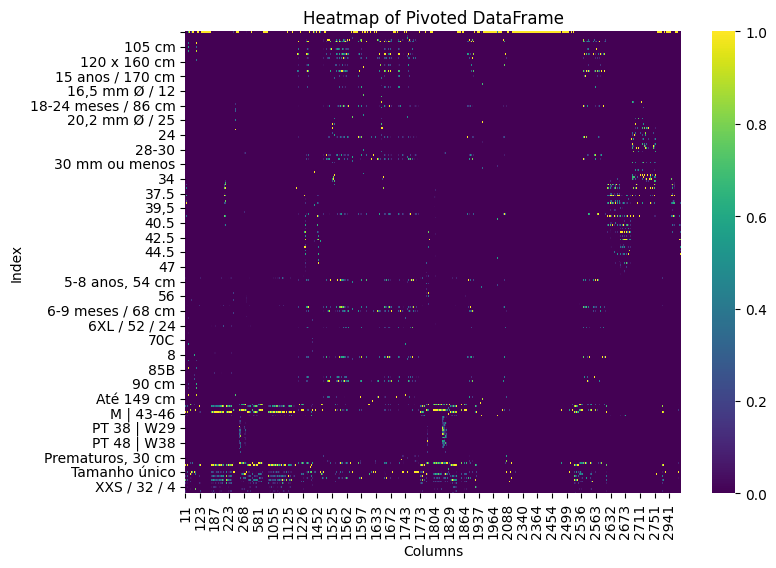

In [401]:

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_combined, cmap='viridis')  # Adjust the colormap as needed
plt.title('Heatmap of Pivoted DataFrame')
plt.xlabel('Columns')
plt.ylabel('Index')

In [402]:
for label in data_with_labels["Cluster"].unique():
    filter = data_with_labels[data_with_labels["Cluster"] == label]
    print(filter.index)


Index([''], dtype='object', name='size_title')
Index(['0-13 kg', '0-3 meses, 30 cm', '1-2 anos, 49 cm', '100 cm',
       '100 x 150 cm', '105 cm', '110 cm', '115 cm', '12 ou mais > 56 cm',
       '120 cm',
       ...
       'S | 35-38', 'S | 38-42', 'Solteiro (135-150 cm x 200-220 cm)', 'XXL',
       'XXL / 44 / 16', 'XXS', 'XXS / 32 / 4', 'XXXL', 'XXXL / 46 / 18',
       'XXXS / 30 / 2'],
      dtype='object', name='size_title', length=217)
Index(['1-3 meses / 56 cm', '11 anos / 146 cm', '12-18 meses / 80 cm',
       '18-24 meses / 86 cm', '24-36 meses / 92 cm', '3 anos / 98 cm',
       '3-6 meses / 62 cm', '4 anos / 104 cm', '5 anos / 110 cm',
       '6-9 meses / 68 cm', '9 anos / 134 cm', '9-12 meses / 74 cm',
       'Até 1 mês / 50 cm', 'XS'],
      dtype='object', name='size_title')
Index(['10 anos / 140 cm', '12 anos / 152 cm', '14 anos / 164 cm',
       '6 anos / 116 cm', '8 anos / 128 cm'],
      dtype='object', name='size_title')
Index(['36', '37', '38', '39', '40'], dtype='ob

Text(70.22222222222221, 0.5, 'Index')

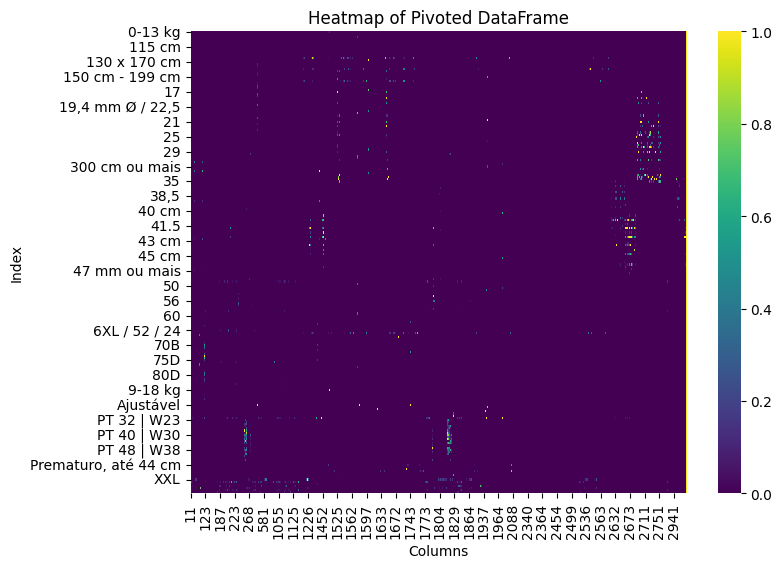

In [412]:
new_df = data_with_labels[data_with_labels["Cluster"] == 1]

plt.figure(figsize=(8, 6))
sns.heatmap(new_df, cmap='viridis')  # Adjust the colormap as needed
plt.title('Heatmap of Pivoted DataFrame')
plt.xlabel('Columns')
plt.ylabel('Index')

Text(0.5, 0, 'Number of points in node (or index of point if no parenthesis).')

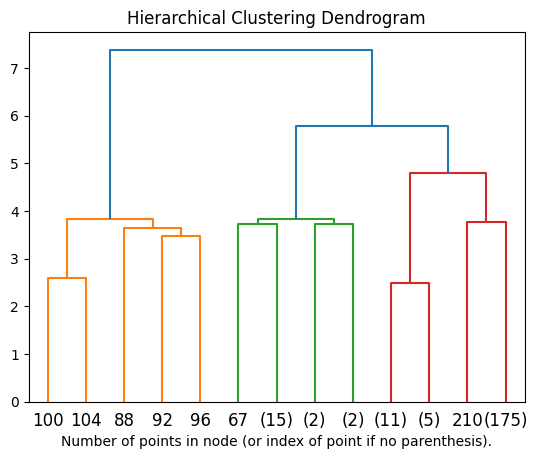

In [413]:
from scipy.cluster.hierarchy import dendrogram

from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(new_df.to_numpy())
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")